参考：https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### データ確認

In [2]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
train

Patient  Weeks   FVC    Percent  Age   Sex  \
0     ID00007637202177411956430     -4  2315  58.253649   79  Male   
1     ID00007637202177411956430      5  2214  55.712129   79  Male   
2     ID00007637202177411956430      7  2061  51.862104   79  Male   
3     ID00007637202177411956430      9  2144  53.950679   79  Male   
4     ID00007637202177411956430     11  2069  52.063412   79  Male   
...                         ...    ...   ...        ...  ...   ...   
1544  ID00426637202313170790466     13  2712  66.594637   73  Male   
1545  ID00426637202313170790466     19  2978  73.126412   73  Male   
1546  ID00426637202313170790466     31  2908  71.407524   73  Male   
1547  ID00426637202313170790466     43  2975  73.052745   73  Male   
1548  ID00426637202313170790466     59  2774  68.117081   73  Male   

     SmokingStatus  
0        Ex-smoker  
1        Ex-smoker  
2        Ex-smoker  
3        Ex-smoker  
4        Ex-smoker  
...            ...  
1544  Never smoked  
1545  Never smoked  
1546  Never smoked  
1547  Never smoked  
1548  Never smoked  

[1549 rows x 7 columns]

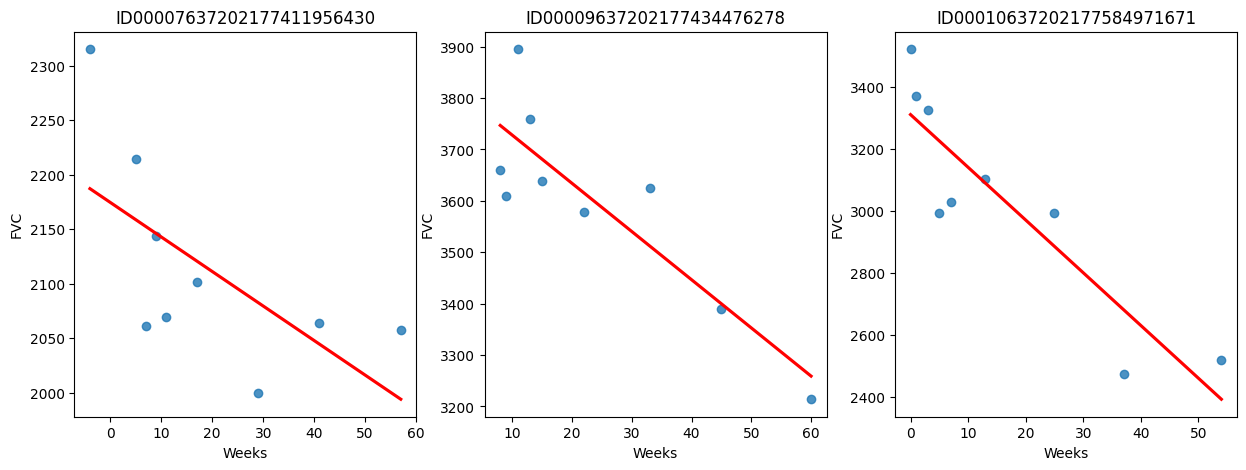

In [3]:
def chart_patient(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    x = data["Weeks"]
    y = data["FVC"]
    ax.set_title(patient_id)
    sns.regplot(x=x, y=y, ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient("ID00007637202177411956430", axes[0])
chart_patient("ID00009637202177434476278", axes[1])
chart_patient("ID00010637202177584971671", axes[2])

FVC(Forced vital capacity):努力肺活量

### Modelling

In [4]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random

In [6]:
def model(patient_code, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

### Fitting the model

In [7]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
train["patient_code"] = patient_encoder.fit_transform(train["Patient"].values)

FVC_obs = train["FVC"].values
Weeks = train["Weeks"].values
patient_code = train["patient_code"].values

In [8]:
train

Patient  Weeks   FVC    Percent  Age   Sex  \
0     ID00007637202177411956430     -4  2315  58.253649   79  Male   
1     ID00007637202177411956430      5  2214  55.712129   79  Male   
2     ID00007637202177411956430      7  2061  51.862104   79  Male   
3     ID00007637202177411956430      9  2144  53.950679   79  Male   
4     ID00007637202177411956430     11  2069  52.063412   79  Male   
...                         ...    ...   ...        ...  ...   ...   
1544  ID00426637202313170790466     13  2712  66.594637   73  Male   
1545  ID00426637202313170790466     19  2978  73.126412   73  Male   
1546  ID00426637202313170790466     31  2908  71.407524   73  Male   
1547  ID00426637202313170790466     43  2975  73.052745   73  Male   
1548  ID00426637202313170790466     59  2774  68.117081   73  Male   

     SmokingStatus  patient_code  
0        Ex-smoker             0  
1        Ex-smoker             0  
2        Ex-smoker             0  
3        Ex-smoker             0  
4        Ex-smoker             0  
...            ...           ...  
1544  Never smoked           175  
1545  Never smoked           175  
1546  Never smoked           175  
1547  Never smoked           175  
1548  Never smoked           175  

[1549 rows x 8 columns]

In [11]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=6000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, patient_code, Weeks, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 8000/8000 [01:11<00:00, 112.10it/s, 255 steps of size 1.22e-02. acc. prob=0.92]


### checking the model

### 学習したパラメータの確認

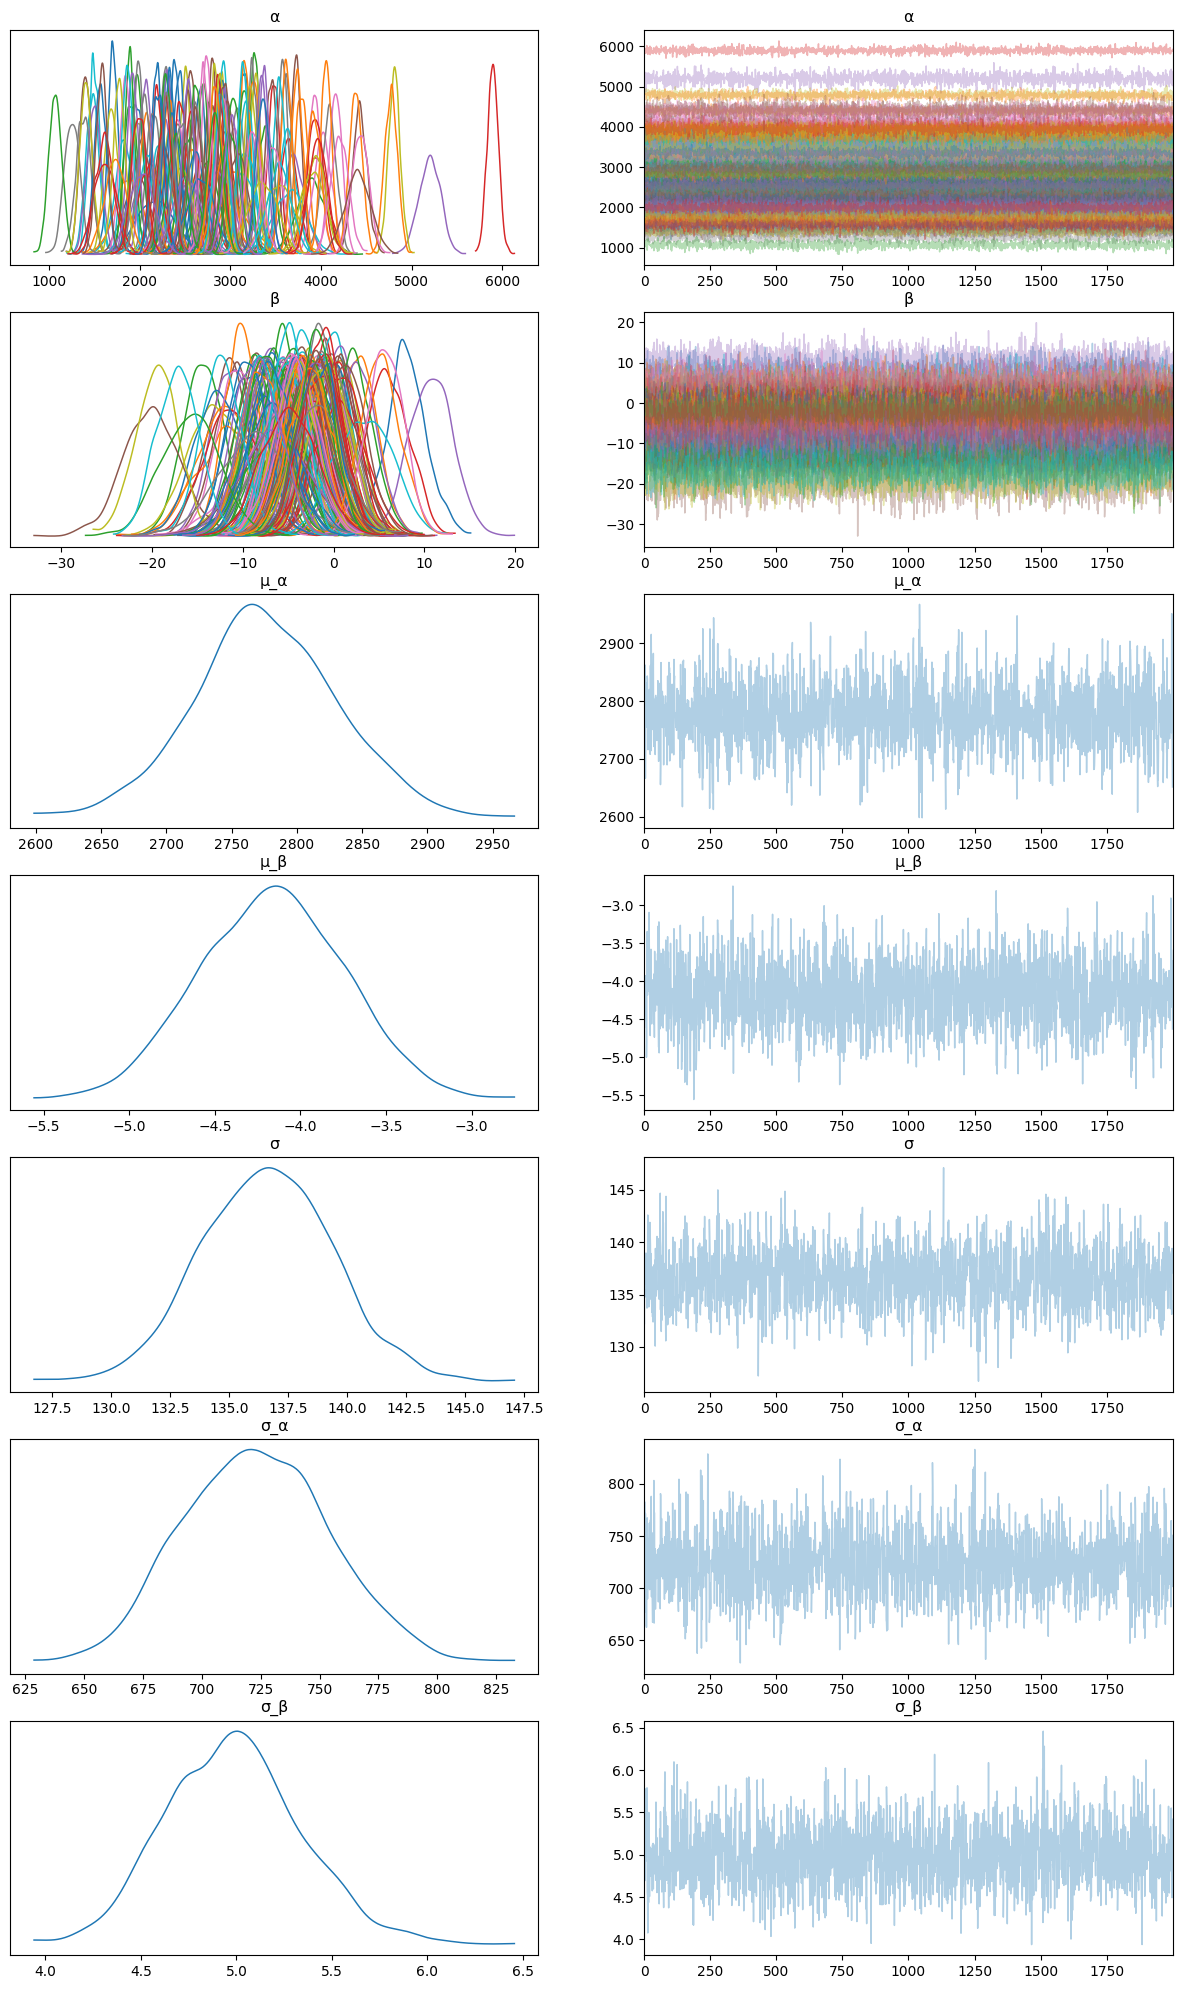

In [12]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));

### 一部の患者について、FVCの減衰曲線を描画

In [13]:
def create_prediction_template(unique_patient_df, weeks_series):
    unique_patient_df["_temp"] = True
    weeks = pd.DataFrame(weeks_series, columns=["Weeks"])
    weeks["_temp"] = True
    return unique_patient_df.merge(weeks, on="_temp").drop(["_temp"], axis=1)

In [20]:
patients = train[["Patient", "patient_code"]].drop_duplicates()
start_week_number = -12
end_week_number = 134
predict_weeks = pd.Series(np.arange(start_week_number, end_week_number))
pred_template = create_prediction_template(patients, predict_weeks)
pred_template

Patient  patient_code  Weeks
0      ID00007637202177411956430             0    -12
1      ID00007637202177411956430             0    -11
2      ID00007637202177411956430             0    -10
3      ID00007637202177411956430             0     -9
4      ID00007637202177411956430             0     -8
...                          ...           ...    ...
25691  ID00426637202313170790466           175    129
25692  ID00426637202313170790466           175    130
25693  ID00426637202313170790466           175    131
25694  ID00426637202313170790466           175    132
25695  ID00426637202313170790466           175    133

[25696 rows x 3 columns]

In [15]:
patient_code = pred_template["patient_code"].values
Weeks = pred_template["Weeks"].values
predictive = Predictive(model, posterior_samples, return_sites=["σ", "obs"])
samples_predictive = predictive(random.PRNGKey(0), patient_code, Weeks, None)

In [23]:
samples_predictive['obs'].shape

(2000, 25696)

In [24]:
df = pred_template.copy()
df["FVC_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["FVC_inf"] = df["FVC_pred"] - df["sigma"]
df["FVC_sup"] = df["FVC_pred"] + df["sigma"]
df = pd.merge(
    df, train[["Patient", "Weeks", "FVC"]], how="left", on=["Patient", "Weeks"]
)
df = df.rename(columns={"FVC": "FVC_true"})
df

Patient  patient_code  Weeks     FVC_pred  \
0      ID00007637202177411956430             0    -12  2227.971436   
1      ID00007637202177411956430             0    -11  2217.629150   
2      ID00007637202177411956430             0    -10  2220.476074   
3      ID00007637202177411956430             0     -9  2216.023682   
4      ID00007637202177411956430             0     -8  2210.020996   
...                          ...           ...    ...          ...   
25698  ID00426637202313170790466           175    129  2714.818604   
25699  ID00426637202313170790466           175    130  2712.538574   
25700  ID00426637202313170790466           175    131  2712.045654   
25701  ID00426637202313170790466           175    132  2704.262695   
25702  ID00426637202313170790466           175    133  2711.147705   

            sigma      FVC_inf      FVC_sup  FVC_true  
0      158.872437  2069.099121  2386.843750       NaN  
1      159.726334  2057.902832  2377.355469       NaN  
2      155.499664  2064.976318  2375.975830       NaN  
3      153.233810  2062.789795  2369.257568       NaN  
4      157.878265  2052.142822  2367.899170       NaN  
...           ...          ...          ...       ...  
25698  281.277252  2433.541260  2996.095947       NaN  
25699  280.573639  2431.964844  2993.112305       NaN  
25700  283.914948  2428.130615  2995.960693       NaN  
25701  282.383301  2421.879395  2986.645996       NaN  
25702  286.770142  2424.377441  2997.917969       NaN  

[25703 rows x 8 columns]

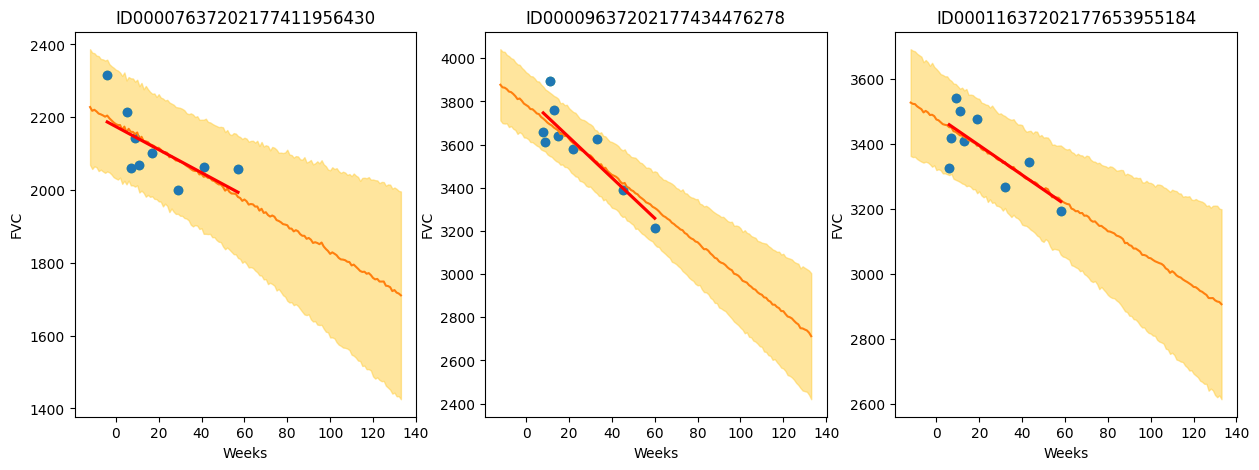

In [18]:
def chart_patient_with_predictions(patient_id, ax):
    data = df[df["Patient"] == patient_id]
    x = data["Weeks"]
    ax.set_title(patient_id)
    ax.plot(x, data["FVC_true"], "o")
    ax.plot(x, data["FVC_pred"])
    ax = sns.regplot(x=x, y=data["FVC_true"], ax=ax, ci=None, line_kws={"color": "red"})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"], alpha=0.5, color="#ffcd3c")
    ax.set_ylabel("FVC")


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient_with_predictions("ID00007637202177411956430", axes[0])
chart_patient_with_predictions("ID00009637202177434476278", axes[1])
chart_patient_with_predictions("ID00011637202177653955184", axes[2])

### Computing the modified Laplace Log Likelihood and RMSE

In [19]:
y = df.dropna()
rmse = ((y["FVC_pred"] - y["FVC_true"]) ** 2).mean() ** (1 / 2)
print(f"RMSE: {rmse:.1f} ml")

sigma_c = y["sigma"].values
sigma_c[sigma_c < 70] = 70
delta = (y["FVC_pred"] - y["FVC_true"]).abs()
delta[delta > 1000] = 1000
lll = -np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f"Laplace Log Likelihood: {lll.mean():.4f}")

RMSE: 122.3 ml
Laplace Log Likelihood: -6.1406


### モデル階層の追加： Smoking Status

In [25]:
train["SmokingStatus"].value_counts()

Ex-smoker           1038
Never smoked         429
Currently smokes      82
Name: SmokingStatus, dtype: int64

In [27]:
patient_code = train["patient_code"].values
Weeks = train["Weeks"].values

smoking_status_encoder = LabelEncoder()
train["smoking_status_code"] = smoking_status_encoder.fit_transform(
    train["SmokingStatus"]
)

smoking_status_code = train["smoking_status_code"].values
smoking_status_code

array([1, 1, 1, ..., 2, 2, 2])

In [29]:
map_patient_to_smoking_status = (
    train[["patient_code", "smoking_status_code"]]
    .drop_duplicates()
    .set_index("patient_code", verify_integrity=True)
    .sort_index()["smoking_status_code"]
    .values
)
map_patient_to_smoking_status

array([1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1,
       0, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 2, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2])

In [32]:
def model_smoking_hierarchy(
    patient_code, Weeks, map_patient_to_smoking_status, FVC_obs=None
):
    μ_α_global = numpyro.sample("μ_α_global", dist.Normal(0.0, 500.0))
    σ_α_global = numpyro.sample("σ_α_global", dist.HalfNormal(100.0))
    μ_β_global = numpyro.sample("μ_β_global", dist.Normal(0.0, 3.0))
    σ_β_global = numpyro.sample("σ_β_global", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))
    n_smoking_statuses = len(np.unique(map_patient_to_smoking_status))

    with numpyro.plate("plate_smoking_status", n_smoking_statuses):
        μ_α_smoking_status = numpyro.sample(
            "μ_α_smoking_status", dist.Normal(μ_α_global, σ_α_global)
        )
        μ_β_smoking_status = numpyro.sample(
            "μ_β_smoking_status", dist.Normal(μ_β_global, σ_β_global)
        )

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample(
            "α",
            dist.Normal(μ_α_smoking_status[map_patient_to_smoking_status], σ_α_global),
        )
        β = numpyro.sample(
            "β",
            dist.Normal(μ_β_smoking_status[map_patient_to_smoking_status], σ_β_global),
        )

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

### Reparameterize the model

In [35]:
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {
    "μ_α_smoking_status": LocScaleReparam(0),
    "μ_β_smoking_status": LocScaleReparam(0),
    "α": LocScaleReparam(0),
    "β": LocScaleReparam(0),
}
reparam_model_smoking_hierarchy = reparam(
    model_smoking_hierarchy, config=reparam_config
)

In [36]:
nuts_kernel = NUTS(reparam_model_smoking_hierarchy, target_accept_prob=0.97)

mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=5000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, patient_code, Weeks, map_patient_to_smoking_status, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 8000/8000 [02:50<00:00, 46.99it/s, 1023 steps of size 5.87e-03. acc. prob=0.97]


### 学習したパラメータの確認

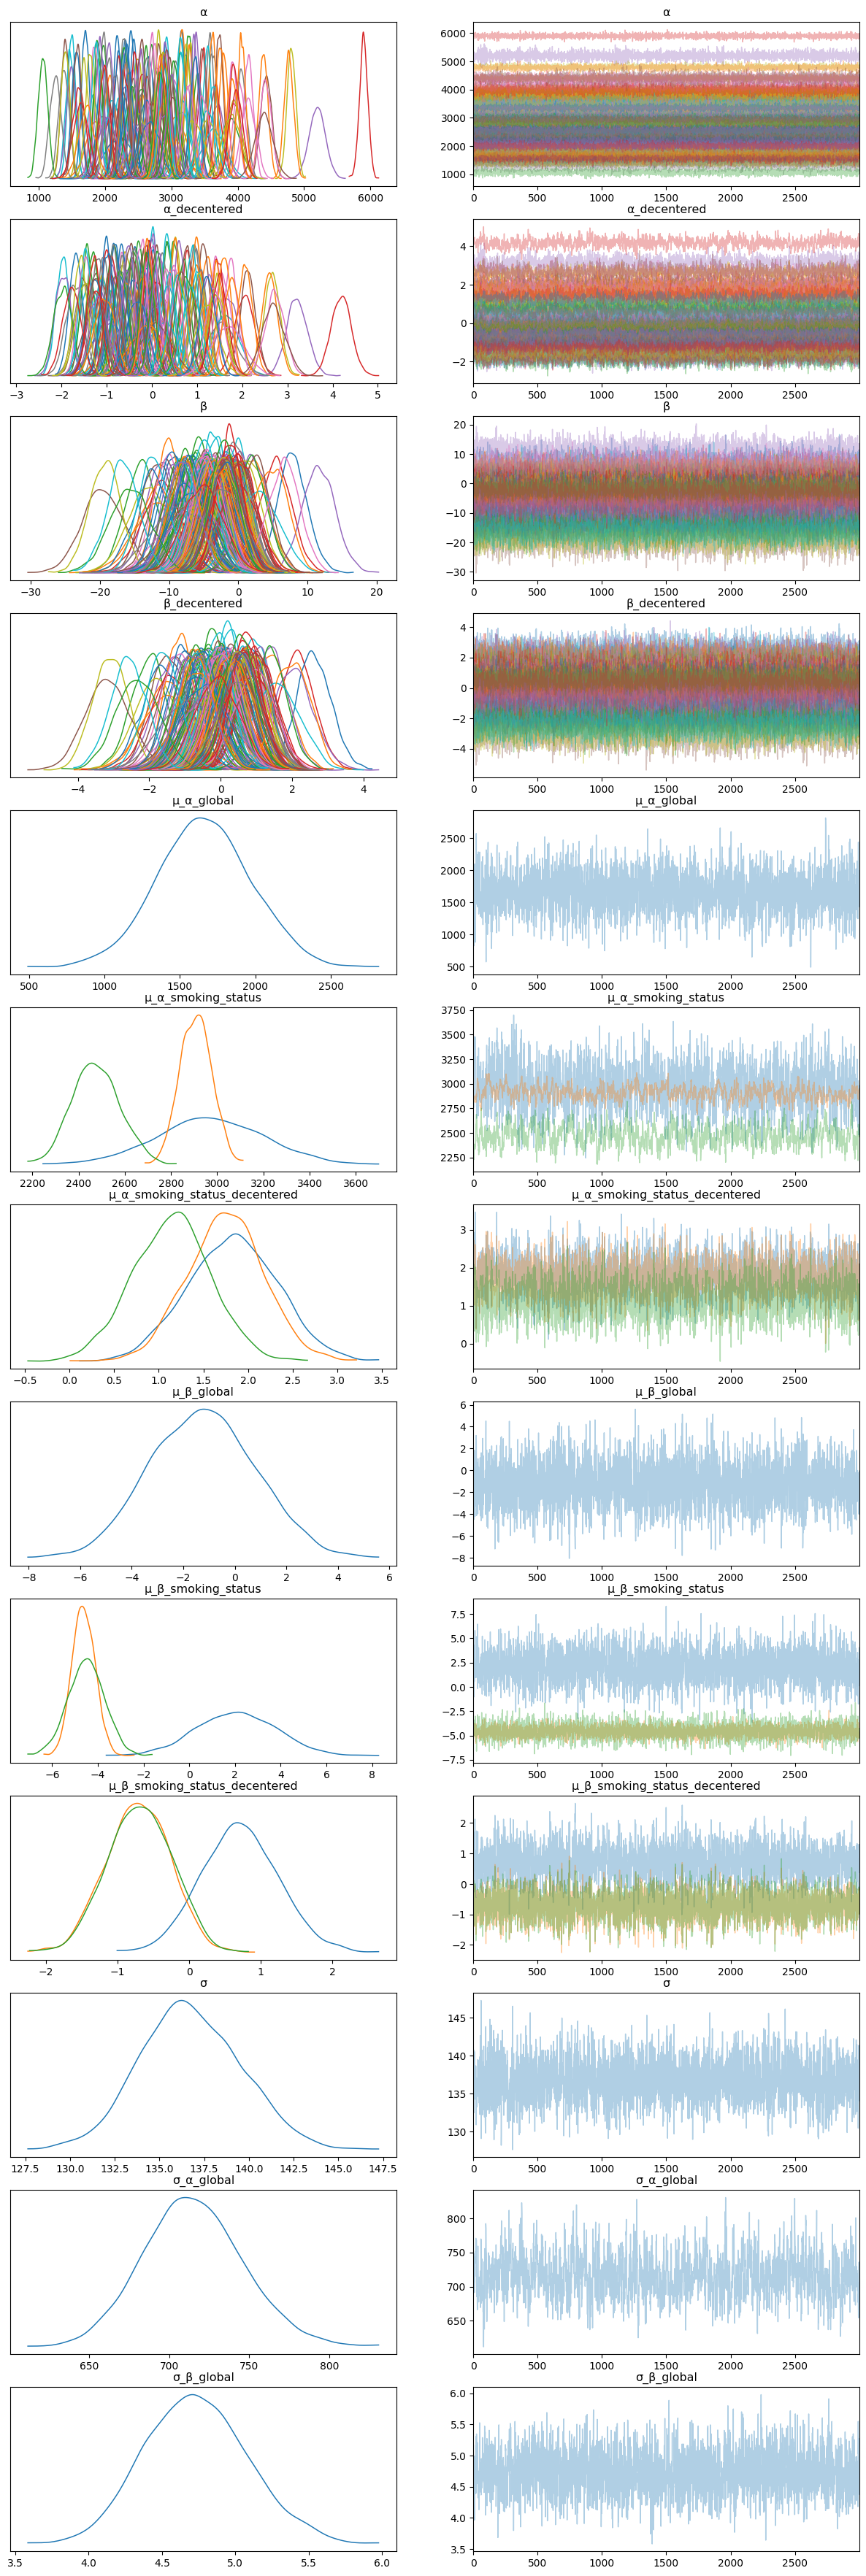

In [37]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 45));

### Smoking Status distributions

In [38]:
# Check the label code for each SmokingStatus
smoking_status_encoder.inverse_transform([0, 1, 2])

array(['Currently smokes', 'Ex-smoker', 'Never smoked'], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


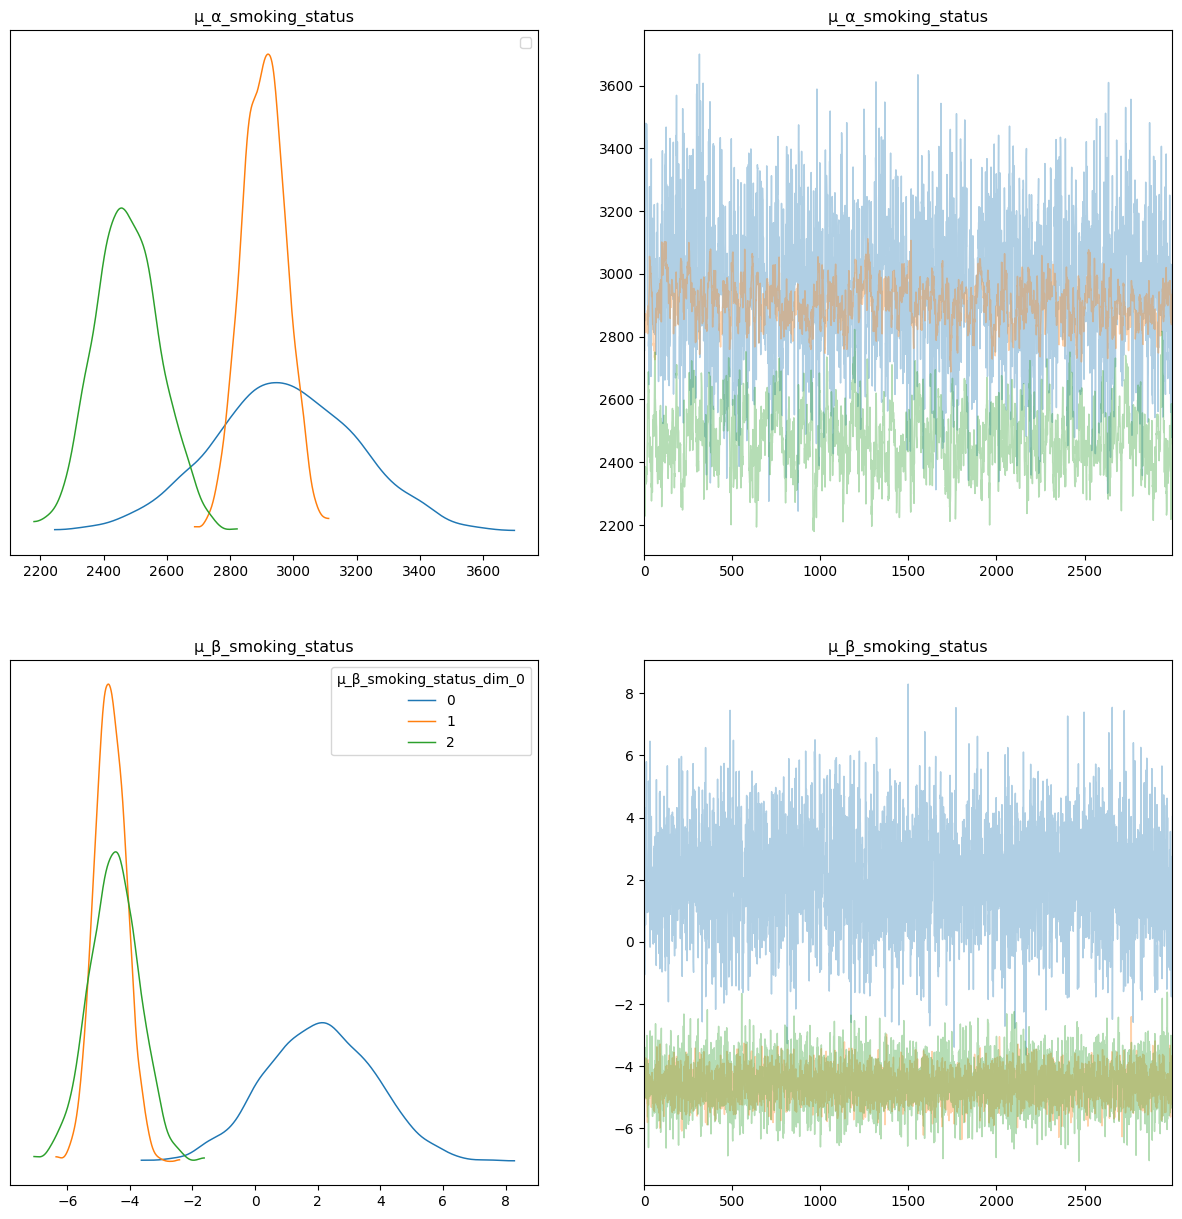

In [39]:
axes = az.plot_trace(
    data,
    var_names=["μ_α_smoking_status", "μ_β_smoking_status"],
    legend=True,
    compact=True,
    figsize=(15, 15),
)
# The legend handles were not working for the first plot
axes[0, 0].legend();

### モデルパラメータの確認

In [40]:

trace = az.from_numpyro(mcmc)
az.summary(
    trace,
    var_names=["μ_α_global", "μ_β_global", "μ_α_smoking_status", "μ_β_smoking_status"],
)

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


mean       sd    hdi_3%   hdi_97%  mcse_mean  \
μ_α_global             1659.359  311.625  1097.312  2260.719      6.466   
μ_β_global               -1.250    2.057    -4.798     2.835      0.036   
μ_α_smoking_status[0]  2968.656  227.771  2542.077  3400.043      7.394   
μ_α_smoking_status[1]  2907.716   68.041  2785.373  3036.292      5.113   
μ_α_smoking_status[2]  2475.478  102.384  2303.754  2686.328      5.936   
μ_β_smoking_status[0]     2.065    1.720    -1.188     5.260      0.031   
μ_β_smoking_status[1]    -4.621    0.497    -5.497    -3.640      0.010   
μ_β_smoking_status[2]    -4.503    0.794    -5.960    -3.005      0.015   

                       mcse_sd  ess_bulk  ess_tail  r_hat  
μ_α_global               4.604    2322.0    2116.0    NaN  
μ_β_global               0.035    3229.0    1947.0    NaN  
μ_α_smoking_status[0]    5.253     951.0    1265.0    NaN  
μ_α_smoking_status[1]    3.629     178.0     317.0    NaN  
μ_α_smoking_status[2]    4.208     299.0     594.0    NaN  
μ_β_smoking_status[0]    0.024    2993.0    2382.0    NaN  
μ_β_smoking_status[1]    0.007    2502.0    2467.0    NaN  
μ_β_smoking_status[2]    0.011    2678.0    2477.0    NaN

### ある患者について、FVCの減衰曲線を描画

In [41]:
patient_code = pred_template["patient_code"].values
Weeks = pred_template["Weeks"].values
predictive = Predictive(
    reparam_model_smoking_hierarchy, posterior_samples, return_sites=["σ", "obs"]
)
samples_predictive = predictive(
    random.PRNGKey(0), patient_code, Weeks, map_patient_to_smoking_status, None
)

In [42]:
df = pred_template.copy()
df["FVC_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["FVC_inf"] = df["FVC_pred"] - df["sigma"]
df["FVC_sup"] = df["FVC_pred"] + df["sigma"]
df = pd.merge(
    df, train[["Patient", "Weeks", "FVC"]], how="left", on=["Patient", "Weeks"]
)
df = df.rename(columns={"FVC": "FVC_true"})
df.head()

Patient  patient_code  Weeks     FVC_pred       sigma  \
0  ID00007637202177411956430             0    -12  2228.350342  158.252136   
1  ID00007637202177411956430             0    -11  2224.226074  156.925949   
2  ID00007637202177411956430             0    -10  2223.711182  154.832291   
3  ID00007637202177411956430             0     -9  2212.002197  154.796616   
4  ID00007637202177411956430             0     -8  2218.441406  155.190628   

       FVC_inf      FVC_sup  FVC_true  
0  2070.098145  2386.602539       NaN  
1  2067.300049  2381.152100       NaN  
2  2068.878906  2378.543457       NaN  
3  2057.205566  2366.798828       NaN  
4  2063.250732  2373.632080       NaN

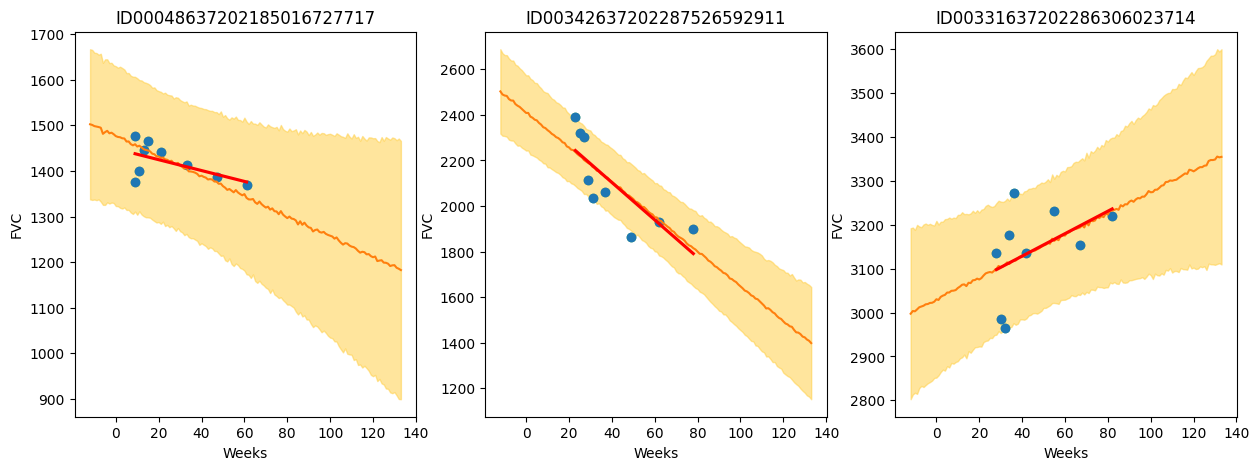

In [43]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient_with_predictions("ID00048637202185016727717", axes[0])  # Never smoked
chart_patient_with_predictions("ID00342637202287526592911", axes[1])  # Ex-smoker
chart_patient_with_predictions("ID00331637202286306023714", axes[2])  # Currently smokes

###  Review patients that currently smoke

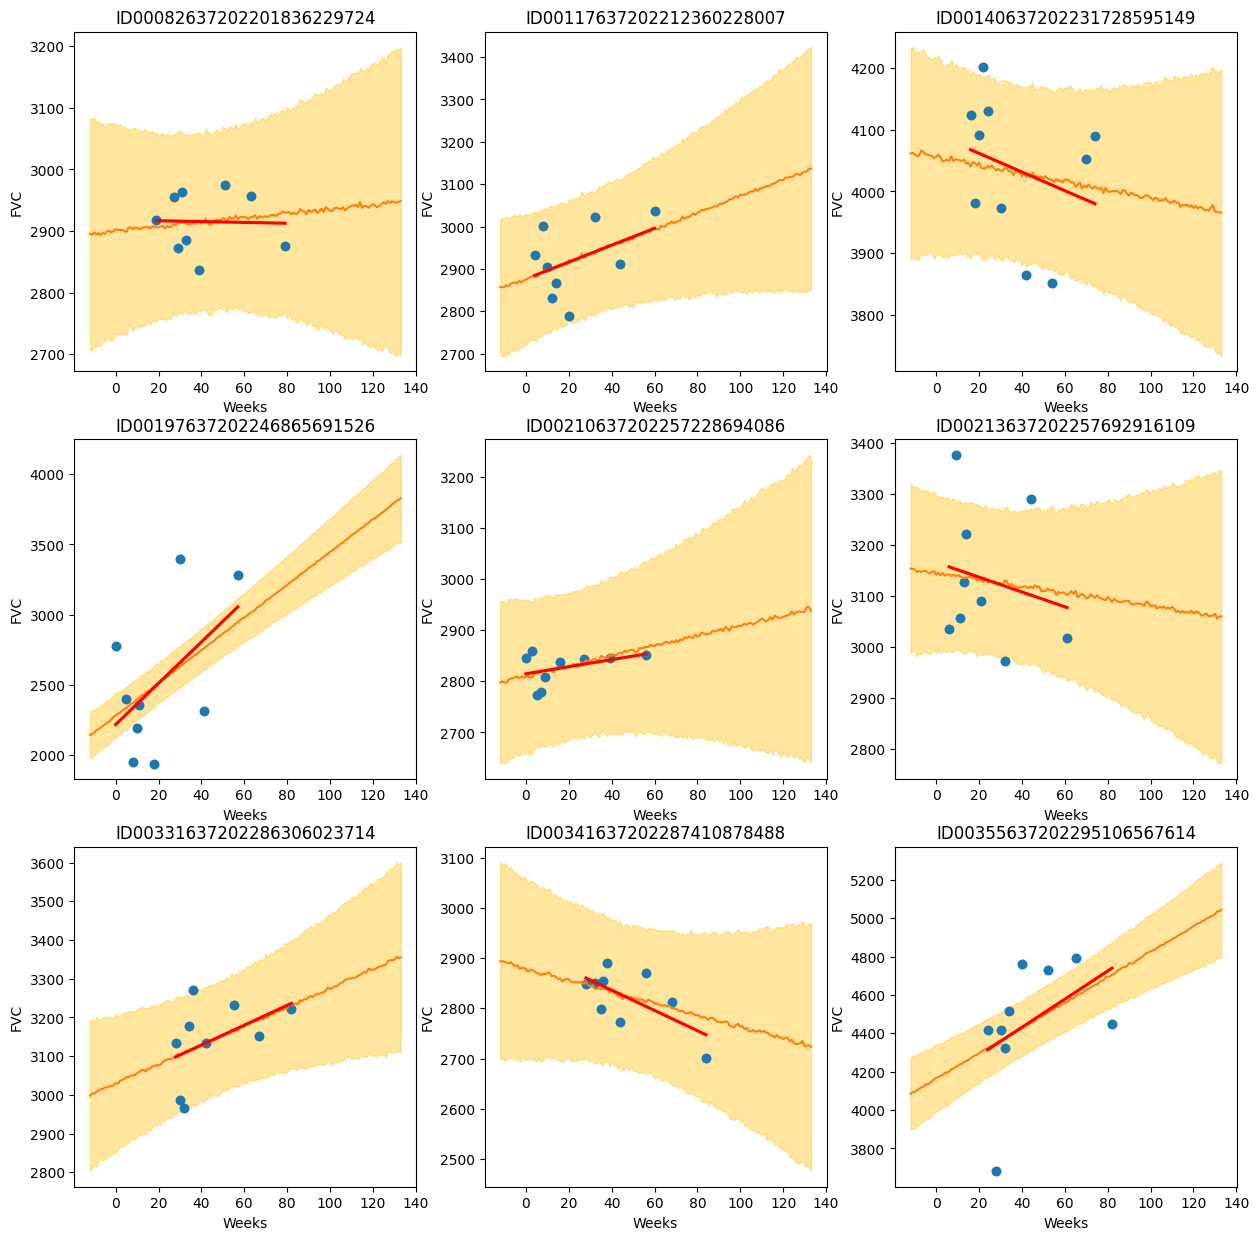

In [44]:
f, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, patient in enumerate(
    train[train["SmokingStatus"] == "Currently smokes"]["Patient"].unique()
):
    chart_patient_with_predictions(patient, axes.flatten()[i])

### スコア評価

In [45]:
y = df.dropna()
rmse = ((y["FVC_pred"] - y["FVC_true"]) ** 2).mean() ** (1 / 2)
print(f"RMSE: {rmse:.1f} ml")

sigma_c = y["sigma"].values
sigma_c[sigma_c < 70] = 70
delta = (y["FVC_pred"] - y["FVC_true"]).abs()
delta[delta > 1000] = 1000
lll = -np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f"Laplace Log Likelihood: {lll.mean():.4f}")

RMSE: 122.6 ml
Laplace Log Likelihood: -6.1419
